# **OBJECTIVE**

In this project, we shall build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. We shall have access to a dataset of 10,000 tweets that were hand-classified apriori, hence contain groud-truth labels. We shall use a binary text classification model which will be trained on these tweets and then later will be used to predict the class labels for an unseen test data.

We shall predict whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

### **Import data from the kaggle directly**

In [1]:
!pip install kaggle

In [2]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# kaggle competition api:

!kaggle competitions download -c nlp-getting-started

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = 'nlp-getting-started.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [5]:
import numpy as np
import pandas as pd
import os, math

#for visualization

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#for text cleaning

import string, re
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#for data analysis and modeling

import tensorflow as tf
import tensorflow_hub as hub
!pip install tensorflow_text
import tensorflow_text
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Embedding, Dropout
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


In [6]:
# reading the train and test data into dataframes
df_train = pd.read_csv('train.csv', index_col='id')
df_test = pd.read_csv('test.csv', index_col='id')


In [7]:
#viewing the top 5 rows in the train dataframe
df_train.head(5)

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
# viewing the top 5 rows in the test dataframe
df_test.head(5)

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
# checking the shape of the dataframes
df_train.shape, df_test.shape

((7613, 4), (3263, 3))

In [10]:
# checking for null values in the train dataframe
df_train.isna().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

In [11]:
# checking for null values in the test dataframe
df_test.isna().sum()

keyword       26
location    1105
text           0
dtype: int64

In [12]:
# checking for duplicate values:

duplicate_count = df_train['text'].duplicated(keep=False).sum()

print("Count of duplicate values:", duplicate_count)

Count of duplicate values: 179


In [13]:
# Drop duplicate values from the 'text' column
df_train.drop_duplicates(subset='text', keep='first', inplace=True)

In [14]:
df_train.shape

(7503, 4)

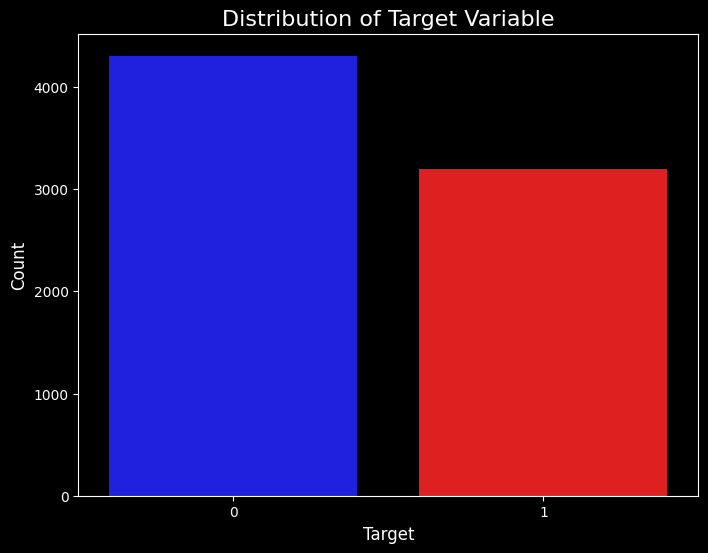

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the dark background style
plt.style.use('dark_background')

# Create a color palette with blue and red
colors = ["blue", "red"]

# Plot the distribution of 'target' variable
plt.figure(figsize=(8, 6))

# Create a bar plot
sns.countplot(data=df_train, x='target', palette=colors)

# Add labels and title
plt.xlabel('Target', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Target Variable', fontsize=16)

# Show the plot
plt.show()


Clearly this is a imbalanced dataset. We will be using F1-score as an evaluation metrics.

### **Identify top 10 commonly used words in target = 1 (disaster)**

In [16]:
def plot_bar(text, title, k=10):
    # Create subplots
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

    # Create and Generate a Word Cloud Image
    wordcloud = WordCloud(width=800, height=800, random_state=1, background_color='white', colormap='Set2', collocations=False, stopwords=STOPWORDS).generate(text)

    # Top k words bar plot
    print(f'Top {k} words: {list(wordcloud.words_.keys())[:k]}')
    sns.barplot(x=0, y=1, data=pd.DataFrame(wordcloud.words_.items()).head(k), ax=ax1)
    ax1.set(xlabel='Words', ylabel='Count', title=title)
    plt.show()

Top 10 words: ['t', 'co', 'fire', 'New', 'Û_', 'amp', 'https', 'via', 'disaster', 'California']


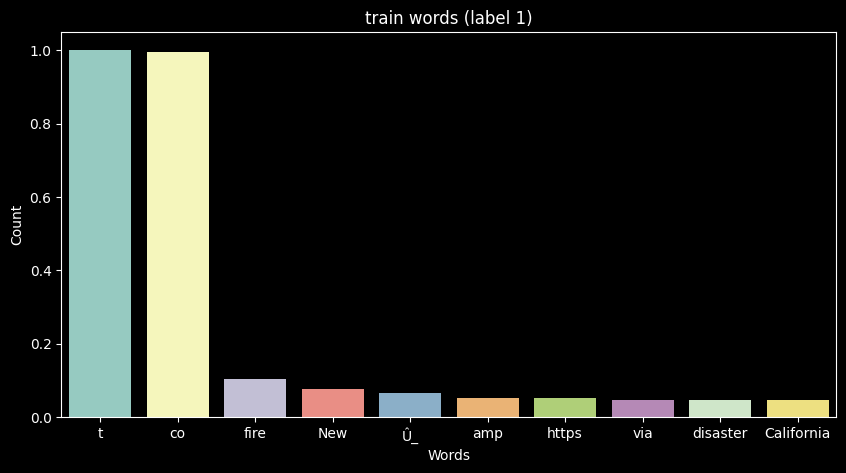

In [17]:
plot_bar(' '.join(df_train[df_train['target']==1]['text'].values), 'train words (label 1)')


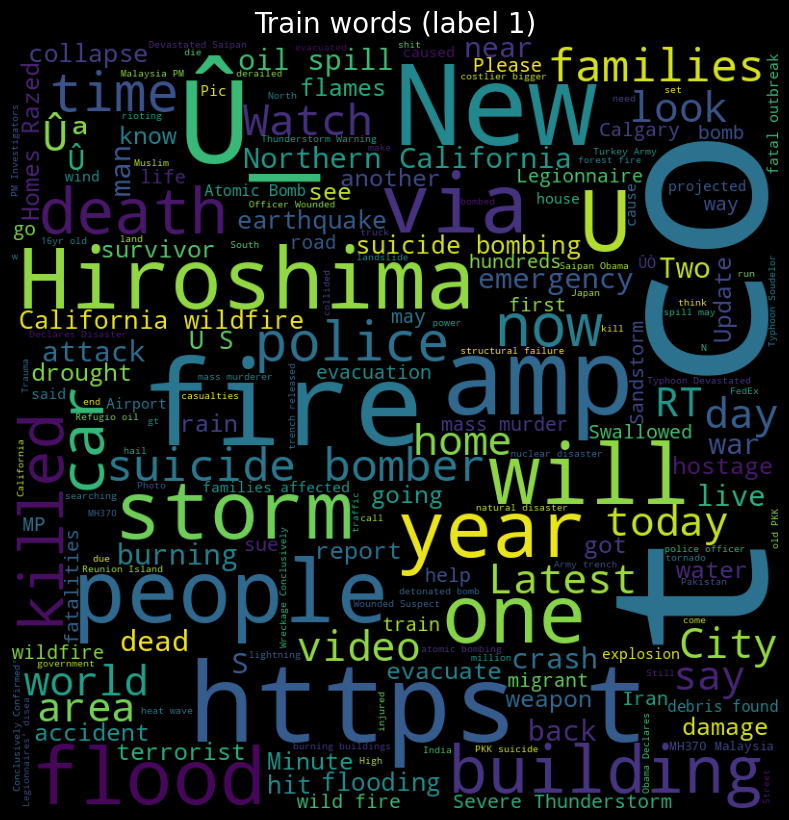

In [18]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def plot_wordcloud(text, title):
    # Define a set of stopwords
    stopwords = set(STOPWORDS)

    # Create the WordCloud
    wordcloud = WordCloud(width=800, height=800,
                          background_color='black',
                          stopwords=stopwords,
                          min_font_size=10).generate(text)

    # Plot the WordCloud image
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title, size=20)
    plt.tight_layout(pad=0)
    plt.show()

# Example usage
text = ' '.join(df_train[df_train['target'] == 1]['text'].tolist())  # Replace with your text data
title = 'Train words (label 1)'

# Plot the Word Cloud
plot_wordcloud(text, title)


### **Identify top 10 commonly used words in target = 0 (not a disaster)**

Top 10 words: ['t', 'co', 'https', 'new', 'amp', 'will', 'Û_', 'u', 'now', 'one']


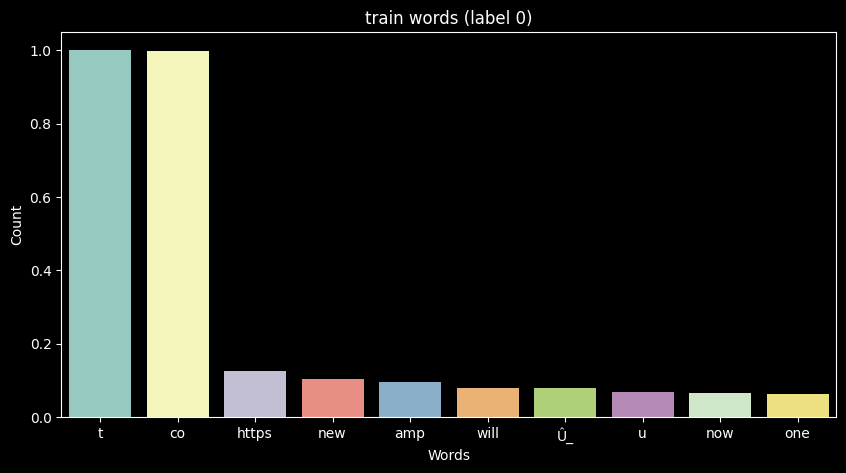

In [19]:
plot_bar(' '.join(df_train[df_train['target']==0]['text'].values), 'train words (label 0)')

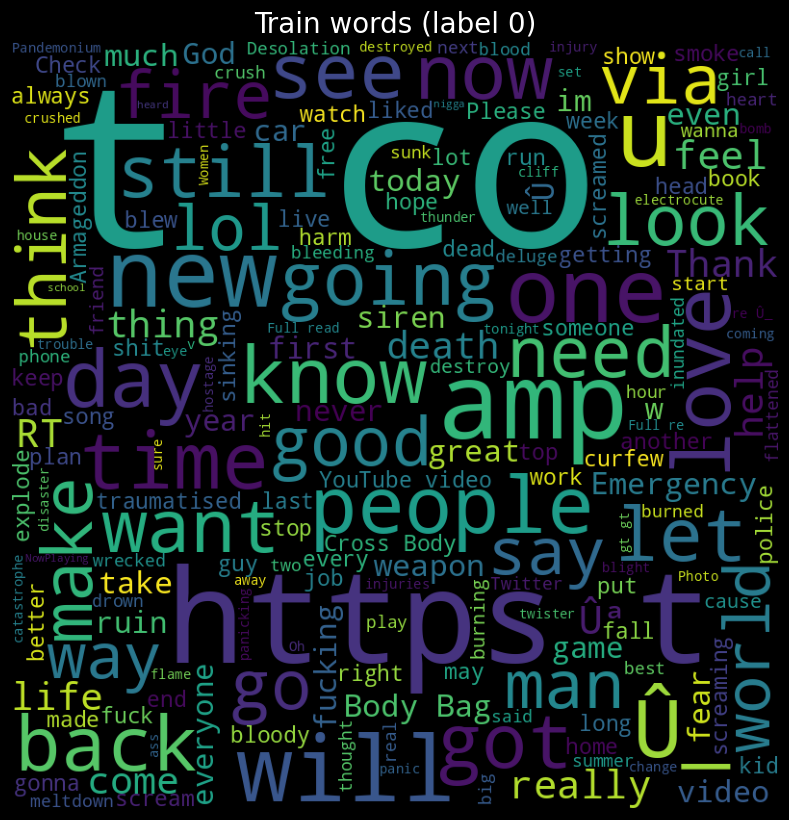

In [20]:
def plot_wordcloud(text, title):
    # Define a set of stopwords
    stopwords = set(STOPWORDS)

    # Create the WordCloud
    wordcloud = WordCloud(width=800, height=800,
                          background_color='black',
                          stopwords=stopwords,
                          min_font_size=10).generate(text)

    # Plot the WordCloud image
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title, size=20)
    plt.tight_layout(pad=0)
    plt.show()

# Example usage
text = ' '.join(df_train[df_train['target'] == 0]['text'].tolist())
title = 'Train words (label 0)'

# Plot the Word Cloud
plot_wordcloud(text, title)


In [21]:
!pip install transformers


In [22]:
# expanding some of the commonly used abbrevations in messaging platform

def prolongation(text):
    text = text.upper()
    text = re.sub(r'bAFAIKb', ' As Far As I Know ',text)
    text = re.sub(r'bAFKb', ' From Keyboard ',text)
    text = re.sub(r'bASAPb', ' As Soon As Possible ',text)
    text = re.sub(r'bATKb', ' At The Keyboard ',text)
    text = re.sub(r'bA3b', ' Anytime, Anywhere, Anyplace ',text)
    text = re.sub(r'bBAKb', ' Back At Keyboard ',text)
    text = re.sub(r'bBBLb', ' Be Back Later ',text)
    text = re.sub(r'bBBSb', ' Be Back Soon ',text)
    text = re.sub(r'bBFNb', ' Bye For Now ',text)
    text = re.sub(r'bBRBb', ' Be Right Back ',text)
    text = re.sub(r'bBRTb', ' Be Right There ',text)
    text = re.sub(r'bBTWb', ' By The Way ',text)
    text = re.sub(r'bB4b', ' Before ',text)
    text = re.sub(r'bB4Nb', ' Bye For Now ',text)
    text = re.sub(r'bCUb', ' See You ',text)
    text = re.sub(r'bCUL8Rb', ' See You Later ',text)
    text = re.sub(r'bCYAb', ' See You ',text)
    text = re.sub(r'bFAQb', ' Frequently Asked Questions ',text)
    text = re.sub(r'bFYIb', ' For Your Information ',text)
    text = re.sub(r'bGNb', ' Good Night ',text)
    text = re.sub(r'bGR8b', ' Great ',text)
    text = re.sub(r'bICb', ' I See ',text)
    text = re.sub(r'bLOLb', ' Laughing Out Loud ',text)
    text = re.sub(r'bL8Rb', ' Later ',text)
    text = re.sub(r'bM8b', ' Mate ',text)
    text = re.sub(r'bTHXb', ' Thank You ',text)
    text = re.sub(r'bTTFNb', ' BYE ',text)
    text = re.sub(r'bTTFNb', ' BYE ',text)
    text = re.sub(r'bUb', ' You ',text)
    text = re.sub(r'bU2b', ' You TOO ',text)
    text = re.sub(r'bWTFb', ' What The Heck ',text)
    text = re.sub(r'bW8b', ' Wait ',text)
    text = re.sub(r'bFAVb', ' Favourite ',text)
    text = re.sub(r'bHWYb'," highway ",text)
    text = re.sub(r'bPPLb'," people ",text)
    text = re.sub(r'bGVb'," give ",text)
    text = re.sub(r'bWANNAb'," want to ",text)
    text = text.lower()
    return text


In [23]:
# Filtering out ASCII characters
def return_ascii(text):
    ret_str = ""
    for char in list(text):
        if char.isascii():
            ret_str += char
    return ret_str


### **Data cleaning process**

In [24]:
import re

def preprocess(text):
    # 1. Removing AM and PM
    text = re.sub(r'[AP]{1}M', ' ', text)

    # 2. Lowercasing
    text = text.lower()

    # 3. Removing mentions
    text = re.sub(r'@\S+', ' ', text)

    # 4. Removing URLs
    text = re.sub(r'https*://\S+', ' ', text)

    # 5. De-abbreviating (You need to define or import the `deabbreviate` function)

    # 6. Cleaning special characters
    text = re.sub(r'[&]+', ' ', text)

    # 7. Removing months
    text = re.sub(r"jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec", ' ', text)

    # 8. Decontracting (You can keep these or remove them)
    # Define decontracting as needed

    # 9. Removing expressions
    text = re.sub(r'A\S+:', ' ', text)

    # 10. Removing punctuations
    punctuations = '!"#$%&()*+,-./:;?@[]^_`{|}~'
    for p in punctuations:
        text = text.replace(p, " ")

    # 11. Removing certain patterns
    text = re.sub(r'lo+l', 'laughing out loud', text)
    text = re.sub(r'coo+l', 'cool', text)
    text = re.sub(r'go+a+l+', 'goal', text)
    text = re.sub(r'so+', 'so', text)
    text = re.sub(r'bo+h+o*b', 'oh', text)

    # 12. Removing digits
    text = re.sub(r'\d+', ' ', text)

    # 13. Replace newlines with spaces
    text = re.sub(r'\n', ' ', text)

    # 14. Removing extra spaces
    text = re.sub(r'\s+', ' ', text)

    # 15. Stripping the end parts
    text = text.strip()

    # 16. Removing accents (You need to define or import the `return_ascii` function)

    # 17. Removing certain patterns after getting only the ascii characters
    text = re.sub(r'cant', 'can not', text)
    text = re.sub(r'wont', 'will not', text)
    text = re.sub(r'imb', 'I am', text)
    text = re.sub(r'didnt', 'did not', text)
    text = re.sub(r'couldnt', 'could not', text)
    text = re.sub(r'isnt', 'is not', text)
    text = re.sub(r'dont', 'do not', text)
    text = re.sub(r'lil', 'little', text)
    text = re.sub(r'alil', 'a little', text)
    text = re.sub(r'view and download video', ' ', text)
    text = re.sub(r'viaZ', ' ', text)

    # 18. Removing words with lengths less than 2
    text = ' '.join([word for word in text.split() if len(word) > 1])

    return text

In [25]:
# preprocessing our data
df_train['text'] = df_train['text'].apply(prolongation).apply(preprocess)
df_test['text'] = df_test['text'].apply(prolongation).apply(preprocess)


### **Model Building**

In [26]:
# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    df_train['text'], df_train['target'], stratify=df_train['target'], random_state=35, test_size=0.2
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, stratify=y_temp, random_state=42, test_size=0.5
)

### **BERT (Bidirectional Encoder Representations from Transformers) model**

In [27]:
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(df_train["target"]),
                                     y= df_train["target"])
class_weights = {k:class_weights[k] for k in np.unique(df_train["target"])}
class_weights

{0: 0.8714285714285714, 1: 1.1730769230769231}

In [28]:
# Define the BERT model
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
'''
def get_BERT_model():
    # Preprocessing
    tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
    # Bert encoder
    tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2'
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    bert_model = hub.KerasLayer(tfhub_handle_encoder)
    input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name='tweets')
    x = bert_preprocess_model(input_layer)
    x = bert_model(x)['pooled_output']
    x = tf.keras.layers.Dropout(0.5)(x) #Optional, to eliminate overfitting
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    classification_out = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(x)
    bert_preprocess_model._name = "preprocess"
    bert_model._name = "bert_encoder"
    model_bert = tf.keras.Model(input_layer, classification_out)
    model_bert._name = "model_bert"
    return model_bert

'''
def get_BERT_model():
    tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
    tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2'
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    bert_model = hub.KerasLayer(tfhub_handle_encoder)
    input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name='tweets')
    x = bert_preprocess_model(input_layer)
    x = bert_model(x)['pooled_output']

    # Additional layers
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)  # Add another dropout layer
    x = tf.keras.layers.Dense(128, activation='relu')(x)  # Add another dense layer
    #x = tf.keras.layers.Dense(64, activation='relu')(x)
    #x = tf.keras.layers.Dense(32, activation='relu')(x)
    #x = tf.keras.layers.Dense(16, activation='relu')(x)
    classification_out = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(x)

    bert_preprocess_model._name = "preprocess"
    bert_model._name = "bert_encoder"

    model_bert = tf.keras.Model(input_layer, classification_out)
    model_bert._name = "model_bert"

    return model_bert

model_bert = get_BERT_model()
model_bert.summary()


Model: "model_bert"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 tweets (InputLayer)         [(None,)]                    0         []                            
                                                                                                  
 preprocess (KerasLayer)     {'input_type_ids': (None,    0         ['tweets[0][0]']              
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                         

In [29]:
%%time
epochs = 120
batch_size = 32

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=False) #logits = data come forom direct output without sigmoid.
metrics = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]

model_bert.get_layer('bert_encoder').trainable = True # need to train

model_bert.compile(optimizer=optimizer, loss=loss, metrics=metrics)


train_data = df_train.sample(frac=0.8,random_state=200)
valid_data = df_train.drop(train_data.index)

history = model_bert.fit(x=df_train.text.values,
                                          y=df_train.target.values,
                                          class_weight=class_weights,
                                          epochs=epochs,
                                          batch_size = batch_size,
                                          validation_data=(valid_data.text.values, valid_data.target.values))

Epoch 1/120
235/235 [==============================] - 39s 109ms/step - loss: 0.5432 - binary_accuracy: 0.7433 - auc: 0.7999 - val_loss: 0.3781 - val_binary_accuracy: 0.8588 - val_auc: 0.9315
Epoch 2/120
235/235 [==============================] - 18s 75ms/step - loss: 0.3860 - binary_accuracy: 0.8486 - auc: 0.9010 - val_loss: 0.3032 - val_binary_accuracy: 0.9061 - val_auc: 0.9523
Epoch 3/120
235/235 [==============================] - 17s 73ms/step - loss: 0.3145 - binary_accuracy: 0.8816 - auc: 0.9347 - val_loss: 0.1949 - val_binary_accuracy: 0.9440 - val_auc: 0.9782
Epoch 4/120
235/235 [==============================] - 16s 68ms/step - loss: 0.2301 - binary_accuracy: 0.9183 - auc: 0.9632 - val_loss: 0.1949 - val_binary_accuracy: 0.9520 - val_auc: 0.9851
Epoch 5/120
235/235 [==============================] - 16s 70ms/step - loss: 0.1937 - binary_accuracy: 0.9323 - auc: 0.9726 - val_loss: 0.1060 - val_binary_accuracy: 0.9620 - val_auc: 0.9903
Epoch 6/120
235/235 [=======================

In [30]:
# After training, evaluating our model on X_test for F1 score

from sklearn.metrics import f1_score

y_pred_test = model_bert.predict(X_test.tolist())
y_pred_test = np.round(y_pred_test).astype(int)
f1_test = f1_score(y_test, y_pred_test)
print(f'F1-Score on Test Data: {f1_test}')

24/24 [==============================] - 1s 41ms/step
F1-Score on Test Data: 0.9827856025039124


In [31]:
X_test = df_test["text"].values
predictions_prob = model_bert.predict(X_test)
predictions = tf.round(predictions_prob)
final_submission = pd.read_csv('sample_submission.csv')
final_submission['target'] = predictions
final_submission['target'] =final_submission['target'].astype(int)
final_submission['id'] = df_test.index
final_submission.to_csv('final_submission.csv', index=False)
final_submission.head()

102/102 [==============================] - 4s 42ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
